In [ ]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.4.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '337627',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEztwcUQ__thumb/img/Ov6eWR87PZ2O1XYQtXMO6KvfzOg=/fit-in/200x150/filters:strip_icc()/pic6153324.jpg',
  'name': 'Voidfall',
  'yearpublished': '2022'},
 {'id': '316624',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/eUiju5SqZbkNt8gnEofrTw__thumb/img/zNkmLNyeXJGOY24FeAAf4U67ejU=/fit-in/200x150/filters:strip_icc()/pic6035127.png',
  'name': 'Stationfall',
  'yearpublished': '2021'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 23)
page number = 20 (max: 100, len: 13)
page number = 30 (max: 100, len: 10)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (83027, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,337627,BGFreakDag2PT,N/A,On Radar
1,337627,Bstalf21,N/A,KS fall?
2,337627,bucklen_uk,N/A,I don't rate my own games (doesn't seem approp...
3,337627,carlcorey,N/A,"Turczi / Mindclash with O'Toole design, intere..."
4,337627,Dark Herald,N/A,Notes: To Consider
...,...,...,...,...
83022,167791,z_zadar,9,Some games are so much fun. Others can be a li...
83023,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
83024,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
83025,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14229 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10        13628
9         12872
8         10724
7          5997
N/A        5824
          ...  
9.849         1
7.78          1
9.17          1
9.2333        1
7.65          1
Name: rating, Length: 498, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(62974, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(5824, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'LC 8'

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


"Don't really get the hype - Wingspan is a pretty standard tableau builder with nice artwork and near zero player interaction. After four games my wife and I didn't have any incentive to play again as the birds are all very similar and the actions themselves didn't feel meaningful at all. okayish game, nothing more."

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[-0.16237031, -0.05009064, -0.15891637,  0.14687212,  0.2252068 ,
         0.00730897, -0.08948039,  0.0214909 , -0.144932  ,  0.17174168,
        -0.01367239, -0.09053041,  0.03496843,  0.06849875, -0.1391235 ,
        -0.02027045,  0.17536227,  0.2974281 ,  0.03926269,  0.02313477,
        -0.21256162,  0.09157778,  0.10012184,  0.28368488,  0.26099846,
        -0.20716955,  0.05314457,  0.06847822, -0.20770219, -0.00608381,
         0.11006093, -0.13822348, -0.1556432 , -0.01513675,  0.35322368,
        -0.06797263,  0.0549089 , -0.13240843,  0.3866089 , -0.16971214,
        -0.05505161, -0.16877115, -0.00526862, -0.10165185, -0.13603258,
         0.07116205,  0.2489617 , -0.17128159, -0.0152873 , -0.00334361],
       [ 0.0867168 , -0.05431235, -0.07459032, -0.05199797, -0.05090012,
         0.08221781,  0.18178725,  0.02340135, -0.26069438,  0.11995125,
         0.18247631, -0.03866523,  0.13961172,  0.03410188,  0.11638098,
 

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
93/93 - 8s - loss: 0.4595 - accuracy: 0.8445 - val_loss: 0.3660 - val_accuracy: 0.8617
Epoch 2/40
93/93 - 5s - loss: 0.3194 - accuracy: 0.8757 - val_loss: 0.3178 - val_accuracy: 0.8736
Epoch 3/40
93/93 - 5s - loss: 0.2637 - accuracy: 0.8961 - val_loss: 0.3077 - val_accuracy: 0.8794
Epoch 4/40
93/93 - 5s - loss: 0.2266 - accuracy: 0.9120 - val_loss: 0.3125 - val_accuracy: 0.8768
Epoch 5/40
93/93 - 5s - loss: 0.1988 - accuracy: 0.9234 - val_loss: 0.3259 - val_accuracy: 0.8723
Epoch 6/40
93/93 - 5s - loss: 0.1769 - accuracy: 0.9329 - val_loss: 0.3447 - val_accuracy: 0.8690
Epoch 7/40
93/93 - 5s - loss: 0.1589 - accuracy: 0.9413 - val_loss: 0.3676 - val_accuracy: 0.8642
Epoch 8/40
93/93 - 5s - loss: 0.1441 - accuracy: 0.9467 - val_loss: 0.3917 - val_accuracy: 0.8613


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

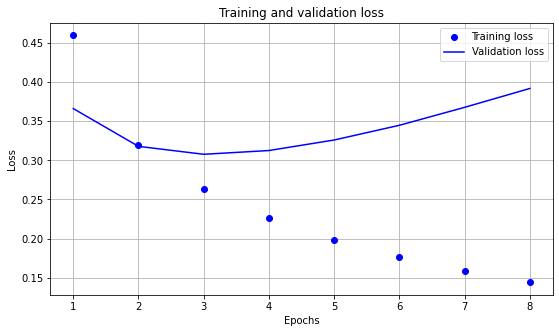

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

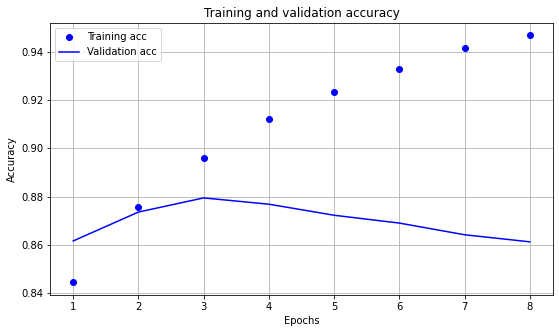

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"Christmas 2019 gift from Punkyy."
score: 0.995172
actual value:1

input:
"I've played this game maybe 65-70 times now and it's still engaging, still interesting, still challenging, and we're still unlocking new things. Couldn't recommend this game enough."
score: 0.999163
actual value:1

input:
"An excellently executed game system which provides a variety of routes to victory and a tension lacking in many other games. Incredibly ambitious in what it seeks to achieve, and is successful in its application. In spite of the frankly tragic graphic design/'illustration', the game is visually intuitive(ish) and surprisingly feels somewhat thematically immersive.  With greater care in design of the thematic fluff, and a redo of the visuals, I could see this being one of the greatest games of the modern era."
score: 0.990016
actual value:1

input:
"A friend owns this together with the Lizard expansion. Takes at least 2-3 games to understand the game fully, but is amazing afterwards. So 

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Regelheft gelesen. Würde ich gerne mal mitspielen."
score: 0.754013

input:
"Also not-shit Monopoly!   Caveat: complex af"
score: 0.193213

input:
"Zweispielerspiel mit Cthulhu"
score: 0.996037

input:
"I bought it for my mother as a Xmass gift and she love it."
score: 0.995975

input:
"Kinda meh actually. It's really good looking, but I find the game pretty bland, as if it's too simple and friendly. I've felt the same about Stegmaier's other games."
score: 0.122948

input:
"Has been so consistently recommended as a great euro (even years after publication) that i want it sight unseen."
score: 0.999991

input:
"MUY BUEN JUEGO, UN EURO AL 100%, EL MEJOR VAQUERO, CONSTRUCTOR E INGENIERO GANARA,  GESTIONAR BIEN TU MAZO DE GANADO TE DARÁ LA VICTORIA, CONCENTRADO EN LAS CARTAS DE OBJETIVO AHÍ ES DONDE HAY MAS PUNTOS. MUY RECOMENDADO"
score: 0.999999

input:
"The Wind Gambit, Invaders from Afar and The Rise of Fenris expansions included. "
score: 0.993932

input:
"Cooperative story-d

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments.head()

,id,username,rating,value,comment_len
41844,169786,ericbad,10,LC 8,2
48116,205637,piett2k,10,"Best (coop) card game ever, cant wait for expa...",41
18900,266192,brasov,6,Don't really get the hype - Wingspan is a pret...,254
11853,316554,kinkykone,5,Rated as would play it again but wouldn't sugg...,46
9527,298047,P.O.G.G.,4,"Good family game, though younger people who ca...",152


In [46]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.351949,3487
1,167355,8.416431,1776
2,167791,8.210223,8206
3,169786,8.100806,7309
4,174430,8.549378,6304


In [47]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [48]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
not_rated_comments_grouped.head()

,id,rating_mean,rating_count
0,162886,8.699674,307
1,167355,9.010849,212
2,167791,8.849312,436
3,169786,8.718367,588
4,174430,8.661092,568


In [65]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")

In [66]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url
0,337627,NaN,NaN,6.766667,3,1,https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEz...,Voidfall,2022,https://boardgamegeek.com/boardgame/337627
1,316624,9.307692,13.0,8.814286,7,2,https://cf.geekdo-images.com/eUiju5SqZbkNt8gnE...,Stationfall,2021,https://boardgamegeek.com/boardgame/316624
2,312484,7.924778,638.0,8.868254,63,3,https://cf.geekdo-images.com/6GqH14TJJhza86BX5...,Lost Ruins of Arnak,2020,https://boardgamegeek.com/boardgame/312484
3,318977,7.898900,209.0,8.950000,16,4,https://cf.geekdo-images.com/1M-1d6fr3U9t670MC...,MicroMacro: Crime City,2020,https://boardgamegeek.com/boardgame/318977
4,277700,8.568293,41.0,9.176744,43,5,https://cf.geekdo-images.com/-JD8JLncWYMes9Q6Y...,Merchants Cove,2021,https://boardgamegeek.com/boardgame/277700


In [67]:
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) / (grouped['rating_count_review']+grouped['rating_count_comments'])

In [68]:
grouped.head()

,id,rating_mean_review,rating_count_review,rating_mean_comments,rating_count_comments,rank,thumbnail,name,yearpublished,url,fixed_rating
0,337627,NaN,NaN,6.766667,3,1,https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEz...,Voidfall,2022,https://boardgamegeek.com/boardgame/337627,NaN
1,316624,9.307692,13.0,8.814286,7,2,https://cf.geekdo-images.com/eUiju5SqZbkNt8gnE...,Stationfall,2021,https://boardgamegeek.com/boardgame/316624,9.135000
2,312484,7.924778,638.0,8.868254,63,3,https://cf.geekdo-images.com/6GqH14TJJhza86BX5...,Lost Ruins of Arnak,2020,https://boardgamegeek.com/boardgame/312484,8.009570
3,318977,7.898900,209.0,8.950000,16,4,https://cf.geekdo-images.com/1M-1d6fr3U9t670MC...,MicroMacro: Crime City,2020,https://boardgamegeek.com/boardgame/318977,7.973644
4,277700,8.568293,41.0,9.176744,43,5,https://cf.geekdo-images.com/-JD8JLncWYMes9Q6Y...,Merchants Cove,2021,https://boardgamegeek.com/boardgame/277700,8.879762


In [69]:
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')

In [70]:
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

In [71]:
grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [72]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [73]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Voidfall,NaN,6.766667,NaN,1,2022
2,,Stationfall,9.307692,8.814286,9.135000,2,2021
3,,Lost Ruins of Arnak,7.924778,8.868254,8.009570,3,2020
4,,MicroMacro: Crime City,7.898900,8.950000,7.973644,4,2020
5,,Merchants Cove,8.568293,9.176744,8.879762,5,2021


In [58]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.307692,8.814286,9.135000,2,2021
2,,Eclipse: Second Dawn for the Galaxy,8.732498,8.644706,8.718036,46,2020
3,,Kemet: Blood and Sand,8.700000,8.811111,8.775949,43,2021
4,,Brass: Birmingham,8.691747,8.850216,8.706490,31,2018
5,,Gloomhaven: Jaws of the Lion,8.617467,8.445865,8.600018,18,2020


In [59]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Stationfall,9.307692,8.814286,9.135000,2,2021
2,,Marvel United: X-Men,1.000000,9.653846,9.035714,17,2022
3,,Merchants Cove,8.568293,9.176744,8.879762,5,2021
4,,Kemet: Blood and Sand,8.700000,8.811111,8.775949,43,2021
5,,Eclipse: Second Dawn for the Galaxy,8.732498,8.644706,8.718036,46,2020


In [60]:
# model.save('saved_model\my_model')

In [61]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [62]:
# some examples on "long" comments vs short comments

In [63]:
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()

In [64]:
# some long comments
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results, limit=25)

input:
"1018  late to the party as this is the 2nd print but just wanted to see for myself what a COIN game looked like"
score: 0.976500

input:
"Card Drafting Dice Rolling Drafting End Game Bonuses Hand Management Set Collection Solo / Solitaire Game"
score: 0.838970

input:
"Two Copies of Base Set (missing one set of token components) Scenario Pack: Curse of the Rougarou Scenario Pack: Carnevale of Horror Scenario Pack: The Meddling of Meowlathotep Arkham Horror Neoprene Game Mat"
score: 0.664452

input:
"Played twice in person and loved it, I want to play again sometime. This game would probably be a 10/10 for me though. "
score: 0.934414

input:
"The infinite beyond expedition Gas giants promo scenario 4 player mats with markers Standees Removable sticker set"
score: 0.999035

input:
"Special thanks to Chris and all of team Tabletop Game Talk. Great podcast and great people. You are all a credit to the hobby. 1-4"
score: 0.999602

input:
"+ Enter the Spider-verse (KS Edition) + Gua